# Variational Autoencoder

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
np.random.seed(42) # for reproducibilty

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

import sys
sys.path.append('../util/')
from util import plotProgress

Using TensorFlow backend.


## Load Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## Declare Parameters

In [3]:
epochs = 100
batch = 128
latent_dim = 2
inter_dims = [400,256,64,10]
optimizer = 'adam'
rate_recon = 0.99999

## Define Samping Function

In [4]:
def sampling(args):
    z_mean,z_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0,stddev=1)
    return z_mean+K.exp(z_log_var/2)*epsilon

## Define Loss Function

In [5]:
def lossVAE(z_mean, z_sigma_log):
    def loss(tensor_input, tensor_decode):
        loss_recon =  metrics.binary_crossentropy(K.flatten(tensor_input), K.flatten(tensor_decode))
        loss_KL = - 0.5 * K.sum(1 + z_sigma_log - K.square(z_mean) - K.exp(z_sigma_log), axis=-1)
        return rate_recon*loss_recon + (1-rate_recon)*loss_KL
    return loss

## Build Encoder

In [6]:
inputs=Input(shape = (X_train.shape[1],))
x = inputs
for inter in inter_dims:
    x = Dense(inter,activation='relu')(x)
z_mean=Dense(latent_dim,activation='linear')(x)
z_log_var=Dense(latent_dim,activation='linear')(x)
encoder = Model(inputs,z_mean,name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               102656    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 433,776
Trainable params: 433,776
Non-trainable params: 0
_________________________________________________________________


## Build Decoder

In [8]:
z=Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])
latent=Input(shape=(latent_dim,))
x=latent
for inter in inter_dims[::-1]:
    x = Dense(inter,activation='relu')(x)
x=Dense(X_train.shape[1],activation='sigmoid')(x)
decoder=Model(latent,x)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_13 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_14 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_15 (Dense)             (None, 400)               102800    
_________________________________________________________________
dense_16 (Dense)             (None, 784)               314384    
Total params: 434,558
Trainable params: 434,558
Non-trainable params: 0
_________________________________________________________________


## Train Autoencoder

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.2401 - val_loss: 0.2108
Epoch 2/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.2024 - val_loss: 0.1958
Epoch 3/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.1910 - val_loss: 0.1872
Epoch 4/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.1848 - val_loss: 0.1826
Epoch 5/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.1817 - val_loss: 0.1805
Epoch 6/100
60000/60000 [==============================] - 5s 80us/step - loss: 0.1791 - val_loss: 0.1783
Epoch 7/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.1772 - val_loss: 0.1783
Epoch 8/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.1759 - val_loss: 0.1774
Epoch 9/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.1753 - val_loss: 0.1

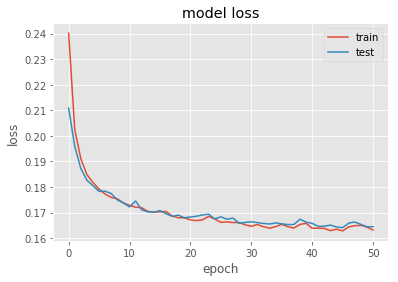

In [9]:
autoencoder = Model(inputs,decoder(z))
autoencoder.compile(optimizer = optimizer,loss = lossVAE(z_mean,z_log_var))
es_cb = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto')
history = autoencoder.fit(X_train, X_train,
                epochs = epochs,
                batch_size = batch,
                shuffle = True,
                callbacks = [es_cb],
                validation_data = (X_test,X_test))
plotProgress(history)

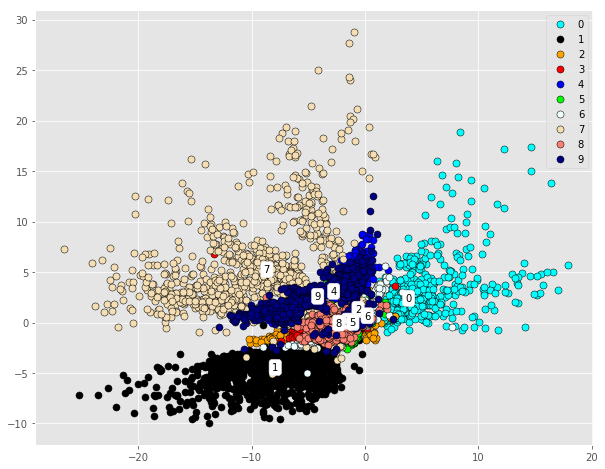

In [10]:
pred = encoder.predict(X_test)
cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
fig,ax = plt.subplots(figsize = (10,8))
for i in range(10):
    ax.scatter(pred[y_test == i,0],pred[y_test == i,1],
               edgecolors = 'black',
               c = cmap[i],
               label = str(i),
               s=50)
    ax.annotate(str(i),(pred[y_test == i,0].mean(),pred[y_test == i,1].mean()),
               bbox = dict(boxstyle = 'round', fc = 'w'))
plt.legend()
plt.savefig('images/clusters_0.5.png',bbox_inches='tight')

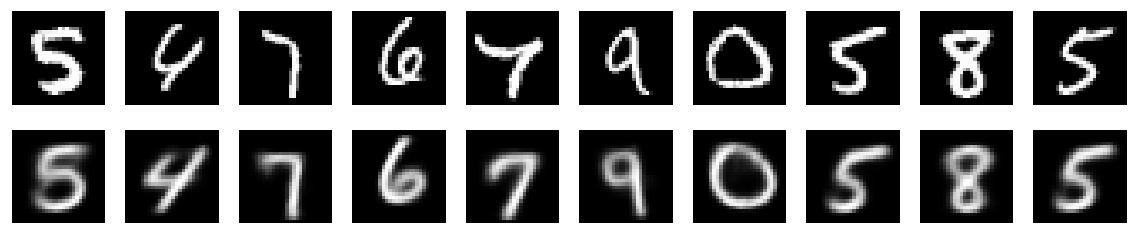

In [11]:
# get decoded digits
reconstructed = decoder.predict(pred)
# plot decoded
n = 10
row = 12
fig = plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('images/digits_0.5.png',bbox_inches='tight')